In [1]:
import glob 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from fastpip import pip
from scipy.signal import savgol_filter    
import scipy
from scipy.optimize import curve_fit

# Preliminar analysis

In this script, I will try to put everything togheder to compute the transition among state ABAB to AAAA obtained by changing the magnetic interaction among particles from purely repulsive to purely attractive. How the magnetic field change in each experiment is explained and computed in script Setting_MagneticField.ipynb. 

In this script, the analisis goes through this points:

    1. find the bifurcation point
    2. Linear fit of the two parts of the channel to refine the bifurcation point
    3. Choose weather the particles go up or down
    4. Pair the particles by NN
    5. Compute the pagnetization value of NN

## 1. 
The interaction cut off will be obtained from the magnetic susceptibility calculation. At 21 mT the particles reach a maximum distance of approx 70 $\mu m$. The size of the particles is 18.82 $\mu m$.

  <span style="color:red">To do: Take an image of scale bar with 10x Objective!</span>

## 2. 
To do that I need to have the tracking trajectories

    Solved: Trajectories obtained in Script Automatic_Tracking

In [2]:
directory = "/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments"

#filenames = [file for file in glob.glob(
#    os.path.join(directory,('*_tracking.dat')))]
#filenames

In [3]:
name = 'EXP3_2023_03_23_15_33_46'

In [4]:
trj = pd.read_csv(os.path.join(directory,(name+'_tracking.dat')),sep = '\t', usecols = ['frame','particle','x','y'])

In [5]:
n_of_particles = len(trj['particle'].unique())
n_of_particles, trj['particle'].unique()

(9, array([  9,  10,  12,  13,  40, 138, 171, 233, 308]))

# Checking tracking

In [6]:
# trj = trj.query('frame < 3600')

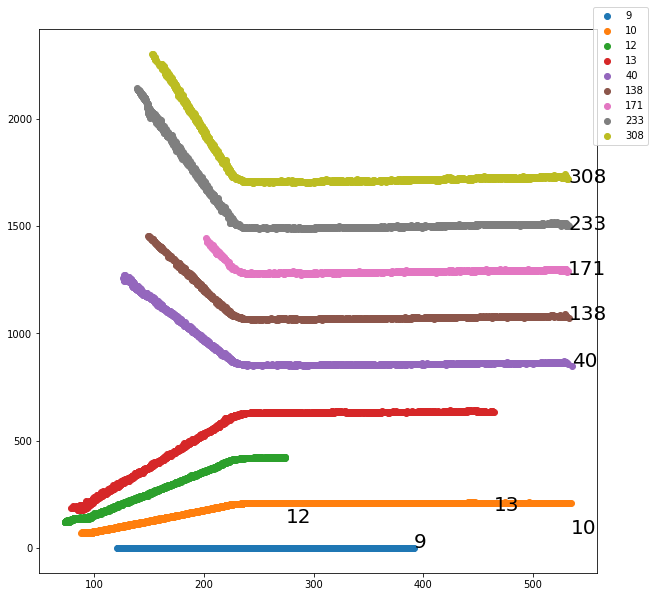

In [7]:
fig, ax = plt.subplots(1, figsize = (10,10))
i = 0
for p, gr in trj.groupby('particle'):
    
    plt.plot(gr.x, gr.y*i, 'o', label = p)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.text(gr.x.max(), gr.y.min()*i, s = str(p), size = 20)
    
    i = i+1

In [8]:
trj = trj[trj.particle != 1600] # To drop unuseful particles

In [8]:
n_of_particles = len(trj['particle'].unique())
n_of_particles, trj['particle'].unique()

(9, array([  9,  10,  12,  13,  40, 138, 171, 233, 308]))

# Functions used during analysis

In [9]:
def y_bifurcation_position(df):
    """In this function I will locate the bifurcation position"""
    
    y, x , _ = plt.hist(df['y'], bins = 40, )
    y_bif = x[np.argmax(y)]
    
    return y_bif, df

def x_bifurcation_position(df, y_bif):
    """In this function I will find the x value of the bifurcation"""
    
    particles = df.particle.unique()
    points = []
    for i in particles:
        
        particle = trj.query('particle =='+str(i))

        data = np.stack((particle.x, particle.y), axis=-1)
        points.append(pip(data,4))
    
    points_ar = np.array(points)
    new_df = points_ar.reshape((len(points_ar[0])*len(points_ar),2))
    df = pd.DataFrame(data=new_df, columns = ['x', 'y'])
    y_bifurcation_plus = y_bif+10
    y_bifurcation_minus = y_bif-10

    df_filtered = df.query('y < '+str(y_bifurcation_plus)+' & y > '+str(y_bifurcation_minus))
    x_bif = df_filtered.x.min()
    return x_bif

In [10]:
def improve_x_and_y_bif(trj, x_bif, y_bif):
    
    """This function will improve the first estimation of x_bif and y_bif
        and will return a fit of the channel"""
    x_int = []
    y_int = []
    fit=[]
    
    for i in range(0,len(trj['particle'].unique())):
        
        particle = trj['particle'].unique()[i] # Select a particle trj
        
        print(particle)

        x1 = trj.query('particle == '+str(particle)+' & x < '+str(x_bif)).x
        y1 = trj.query('particle == '+str(particle)+' & x < '+str(x_bif)).y

        x2 = trj.query('particle == '+str(particle)+' & x > '+str(x_bif)).x
        y2 = trj.query('particle == '+str(particle)+' & x > '+str(x_bif)).y
            
        fit1 = np.poly1d(np.polyfit(x1, y1, 1)) # fit biburcation
        fit2 = np.poly1d(np.polyfit(x2, y2, 1)) # fit channel

        fit.append(np.poly1d(np.polyfit(x2, y2, 1))) # fit channel
        # compute intersection among fits
        x_int.append((fit2[0]-fit1[0])/(fit1[1]-fit2[1]))
        y_int.append(fit1[1]*x_int[i]+fit1[0])
        
    x_int = np.mean(x_int)
    y_int = np.mean(y_int)
    
    return x_int, y_int, fit

In [11]:
def up_or_down(df, y_bif):
    
    """This function indicates which channel the particle has choose.
    The information is stored in the column bif."""
    
    df_trj = df[df.duplicated(subset=['frame'], keep=False)]  # Keep only frames that have more than one particle

    df_trj['bif'] = np.NaN
    for p,df in df_trj.groupby('particle'):
        
        if df.iloc[-1].y > y_bif:
            df_trj.loc[trj.particle==p,'bif'] = 'UP'
        else:
            df_trj.loc[trj.particle==p,'bif']= 'DOWN'
        
    return df_trj

In [12]:
def create_pairs(df, frame):
    """This function generates pair of particles. A pair of particle is defined 
    when one particles enter to the channel after the other. So, consecutive
    particles will be part of a pair.
    This function works for one frame"""

    df_f = df.query('frame == '+str(frame)) # First select a frame

    df_order = df_f.sort_values(by = ['x'])       # Order the x column in ascendent values, 
                                                  # this will be the order of particles entering the chanel. 
    new_df = []
    keys = []
    p1 = []
    p2 = []
    j = 2
    
    for i in range(0, len(df_order)-1):       
        
        p1.append(df_order.iloc[i:j].particle.values[0])
        p1.append(df_order.iloc[i:j].particle.values[0])


        p2.append(df_order.iloc[i:j].particle.values[1])
        p2.append(df_order.iloc[i:j].particle.values[1])

        new_df.append(df_order.iloc[i:j])  # Join consecutive rows, generating pairs
      

        keys.append(i)
        j = j +1
    p1 = pd.DataFrame({'p1':p1})
    p2 = pd.DataFrame({'p2':p2})

    final_df = pd.concat(new_df, keys = keys, names = ['pairs','index'])
    pairs = pd.concat([p1,p2], axis = 1)
    
    final_df['p1'] = pairs['p1'].values
    final_df['p2'] = pairs['p2'].values
    
    return final_df

In [13]:
def magnetization(df, frame):
    
    """Magnetization is equal to 1 when the 2 particles choose the same channel
        Magnetization is equal to 0 when the particles choose different channels"""
    
    df = df.query('frame == '+str(frame))
    magnetization = []
    for ind,group in df.groupby(['pairs']):

        if len(np.unique(group.bif)) == 2:

            magnetization.append(0)
            magnetization.append(0)

        else:

            magnetization.append(1) 
            magnetization.append(1)


    df['magnetization'] = magnetization
    return df

In [14]:
def d(df , pix = float, um = float):  
    "With this function I will compute the distance among particles."
    
    df['distance'] = np.NaN # Crate new column
    dx = []
    dy = []
    grouped = df.groupby(['frame','pairs'])
    for name,group in grouped:
        
        dx.append((np.sqrt((group.x.diff(periods=-1).values)**2)[0])*(um/pix))
        dx.append((np.sqrt((group.x.diff(periods=-1).values)**2)[0])*(um/pix))
    
        dy.append((np.sqrt((group.y.diff(periods=-1).values)**2)[0])*(um/pix))
        dy.append((np.sqrt((group.y.diff(periods=-1).values)**2)[0])*(um/pix))
    
    df['dx'] = dx
    df['dy'] = dy
    
    return df

In [15]:
def check_analysis(trj_initial,last_df_analyzed):
    
    n_of_particles = len(trj_initial['particle'].unique())
    n_of_pairs = len(last_df_analyzed.groupby(['p1','p2']).size())
    
    if (n_of_particles == n_of_pairs+1):
        
        print("Analysis succesfully performed of video")
    else:
        print("Something was wrong during tracking or analysis. We detect N partcles and not N-1 pairs")

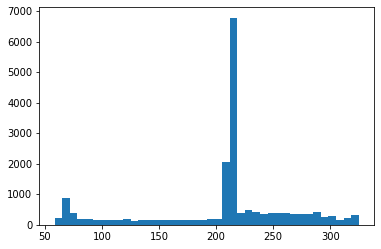

In [16]:
y_bif, df = y_bifurcation_position(trj)
x_bif = x_bifurcation_position(trj, y_bif)

In [17]:
x_bif

225.40307412276263

In [18]:
x_bif, y_bif, fit = improve_x_and_y_bif(trj,230, y_bif)


9
10
12
13
40
138
171
233
308


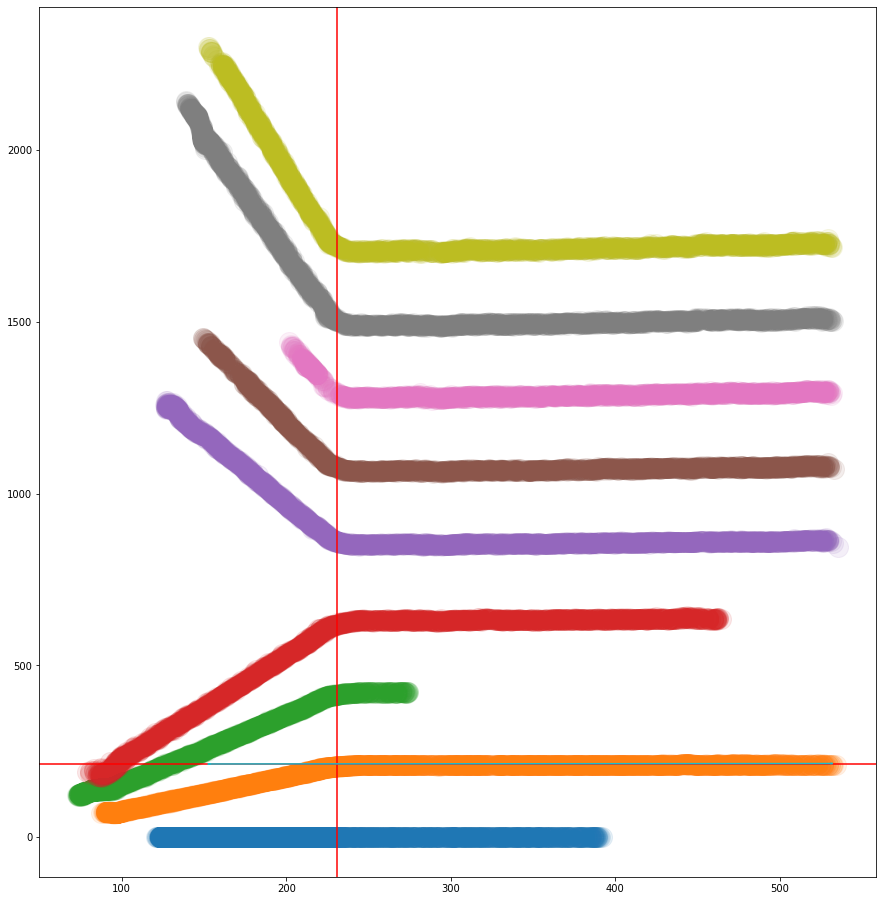

In [19]:
fig, ax = plt.subplots(1,1,figsize=(15,16))
j = 0
for p,trj_p in trj.groupby("particle"):
    ax.plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    j = j+1
plt.axhline(y=y_bif, color='r', linestyle='-')
plt.axvline(x=x_bif, color='r', linestyle='-')
plt.plot(trj_p.x, trj_p.x*fit[0][1]+fit[0][0])

In [20]:
fit

[poly1d([3.57055815e-03, 2.12772885e+02]),
 poly1d([8.15202702e-03, 2.07463350e+02]),
 poly1d([6.22570190e-02, 1.94585243e+02]),
 poly1d([1.10554927e-02, 2.07137066e+02]),
 poly1d([9.52945028e-03, 2.10609309e+02]),
 poly1d([9.60158862e-03, 2.10688425e+02]),
 poly1d([9.79676349e-03, 2.10737752e+02]),
 poly1d([1.00372789e-02, 2.10253685e+02]),
 poly1d([1.00743738e-02, 2.10579698e+02])]

In [21]:
inter = up_or_down(trj,y_bif)

/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/carolina/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


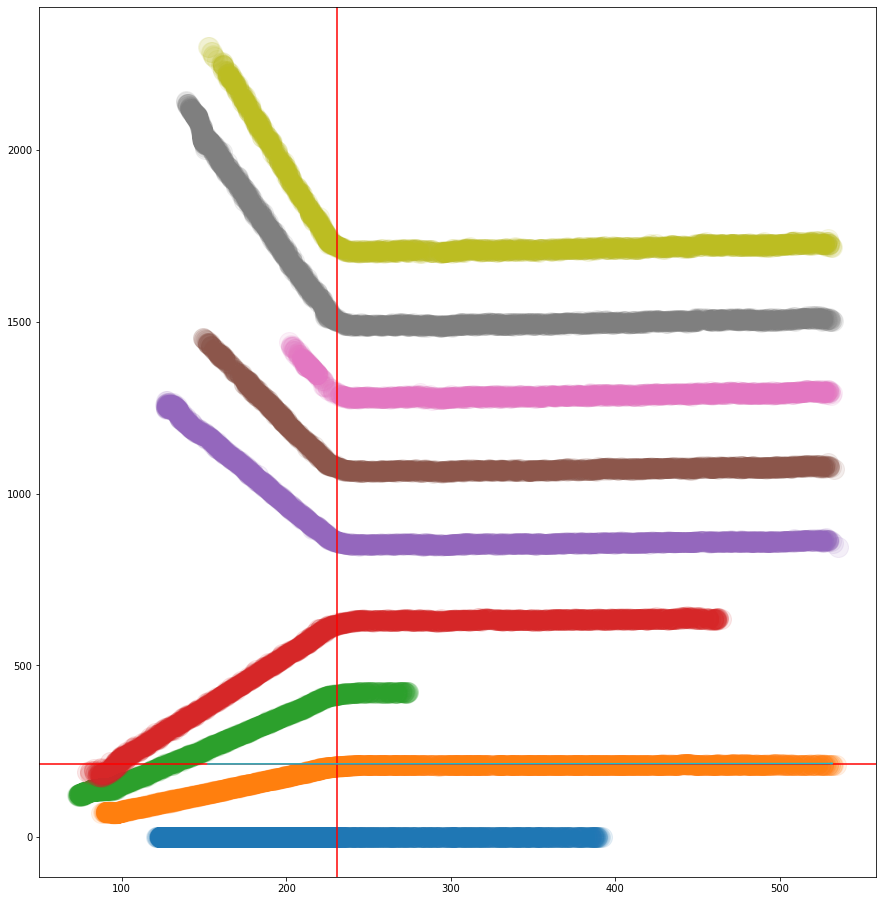

In [22]:
fig, ax = plt.subplots(1,1,figsize=(15,16))
j = 0
for p,trj_p in inter.groupby("particle"):
    
    ax.plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    j = j+1
plt.axhline(y=y_bif, color='r', linestyle='-')
plt.axvline(x=x_bif, color='r', linestyle='-')
plt.plot(trj_p.x, trj_p.x*fit[0][1]+fit[0][0])

In [23]:
len(trj), len(inter)

(18968, 18674)

In [24]:
df_x = inter.query('x > '+str(x_bif))
    
df_d = df_x[df_x.duplicated(subset=['frame'], keep=False)]

In [25]:
len(df_x), len(df_d)

(8488, 7735)

9
10
12
13
40
138
171
233
308


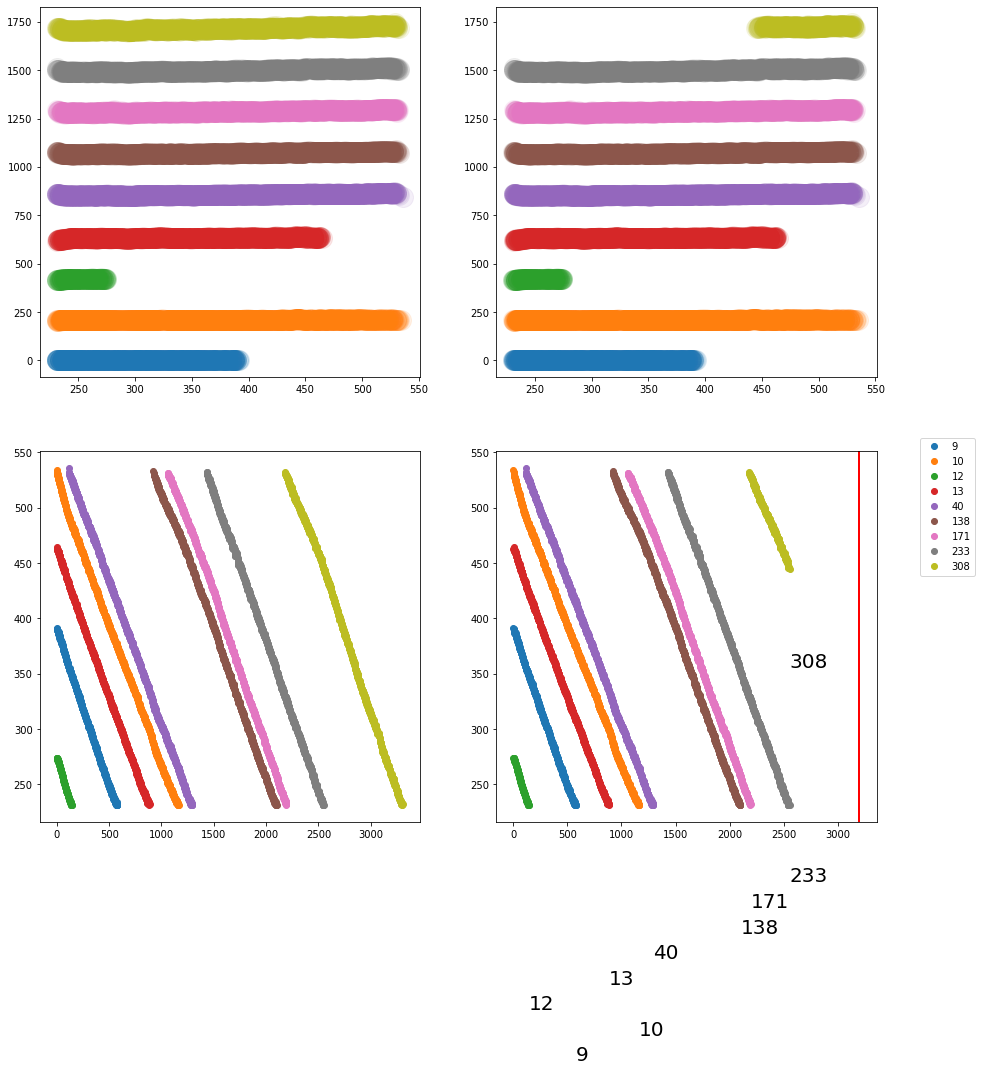

In [26]:
fig, (ax0,ax1) = plt.subplots(2,2, figsize = (15,15))

j = 0
for p,trj_p in df_x.groupby("particle"):
    
    ax0[0].plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    ax1[0].plot(trj_p.frame, trj_p.x, 'o')
    j = j+1
    
j = 0
for p,trj_p in df_d.groupby("particle"):
    
    ax0[1].plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    ax1[1].plot(trj_p.frame, trj_p.x, 'o', label = str(p))
    ax1[1].text(trj_p.frame.max(), trj_p.x.min()*0.1*j , s = str(p), size = 20)
    ax1[1].axvline(x=3200, color='r', linestyle='-')
    ax1[1].legend(bbox_to_anchor=(1.1, 1.05))


    print(str(p))

    

    j = j+1

In [27]:
#df_d.query('frame == 3200')

In [28]:
%%time
df_last = []

df_x = inter.query('x > '+str(x_bif)+'& x < 500') # 500 is the starting point of the channel
    
df_d = df_x[df_x.duplicated(subset=['frame'], keep=False)]

for frame in df_d['frame'].unique(): # Do analysis frame by frame
    
    pairs = create_pairs(df_d, frame)
    mag = magnetization(pairs, frame)
    df_last.append(d(mag, 1, 1)) # I need to introduce the pix/um conversion.

    
last = pd.concat(df_last)    

CPU times: user 26.8 s, sys: 534 ms, total: 27.3 s
Wall time: 26.8 s


In [29]:
check_analysis(trj, last)

Analysis succesfully performed of video


In [30]:
len(last.particle.unique())

9

In [31]:
last.groupby(['p1','p2']).size(), len(last.groupby(['p1','p2']).size())

(p1   p2 
 9    13     1154
 10   40     1848
 12   9       284
 13   10     1590
 40   138     482
 138  171    1802
 171  233    1304
 233  308     464
 dtype: int64,
 8)

In [42]:
last1 = last[last.p1 != 32] # To drop unuseful particles

In [43]:
last1.groupby(['p1','p2']).size()

p1   p2
31   36    2922
33   32    2812
34   33    1264
35   34     596
36   39    3066
39   48    4520
42   41    3054
45   47    5020
47   42    3238
48   45    4612
188  31    5024
dtype: int64

In [47]:
last1 = last[(last.p1 == 37) & (last.p2 == 34)]
last1.groupby(['p1','p2']).size() 

p1  p2
37  34    2566
dtype: int64

In [47]:
last1 = last.query('p1 == 32 & p2 == 188')


In [78]:
last1.groupby(['p1','p2']).size() 

p1  p2
14  48    1422
dtype: int64

In [49]:
last.groupby(['p1','p2']).size() 

p1  p2
13  37    1914
dtype: int64

In [142]:
last1 = last[(last['p1'] == 14) & (last['p2'] == 1680)]
last1.groupby(['p1','p2']).size() 

p1    p2  
1399  1680    1266
dtype: int64

# Next step

Now I need to compute the main distance in the channel for pairs of particles and associate a magnetization value to this pair.

In [32]:
def distance_and_magnetization(df, x_bif):
    
    output = df.groupby(['p1','p2']).mean()
    output['dx_err'] = df.groupby(['p1','p2']).dx.std()/np.sqrt(df.groupby(['p1','p2']).count()['dx'])
    output['dy_err'] = df.groupby(['p1','p2']).dy.std()/np.sqrt(df.groupby(['p1','p2']).count()['dy'])

    
    return output

In [33]:
output = distance_and_magnetization(last,x_bif)
output

,,frame,particle,y,x,magnetization,distance,dx,dy,dx_err,dy_err
p1,p2,,,,,,,,,,
9,13,288.005199,11.0,212.624633,346.136637,0.0,NaN,76.765691,2.450664,0.073451,0.023037
10,40,699.505411,25.0,212.241654,362.760956,0.0,NaN,38.075720,3.772475,0.055915,0.018137
12,9,70.507042,10.5,212.278004,310.627101,0.0,NaN,117.579083,3.918397,0.059413,0.052725
13,10,486.002516,11.5,210.820978,365.132879,1.0,NaN,65.303188,0.581349,0.062150,0.013323
40,138,1171.950207,89.0,214.322480,367.517573,1.0,NaN,214.332501,2.027431,0.128324,0.031237
138,171,1648.002220,154.5,214.200299,365.207982,1.0,NaN,30.826531,0.585645,0.039615,0.009909
171,233,1868.498466,202.0,214.079002,367.205641,1.0,NaN,94.712368,0.671576,0.061349,0.013324
233,308,2431.525862,270.5,214.275650,368.330938,1.0,NaN,212.496231,2.439328,0.158481,0.027031


In [34]:
output.to_csv('magnetization_'+name+'.dat', sep = '\t')